# Initial Settings

## Libraries Versions

In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import seaborn
import sys

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", seaborn.__version__)

Python: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas: 2.1.4
NumPy: 1.26.4
Scikit-learn: 1.2.2
Matplotlib: 3.8.0
Seaborn: 0.13.2


## Importing Libraries

In [128]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Preprocessing and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.base import clone
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# Utilities
import time
import shap

# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')

# Loading and Overview of the Dataset

In [7]:
# Load the dataset from the Kaggle competition
df = pd.read_csv("..\data\Customer-Churn-Records.csv")

# Display the first few rows to get an overview of the dataset structure
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [8]:
# The RowNumber, Surname and CustomerId column are not required for training or visualization
df = df.drop(columns=['RowNumber','CustomerId','Surname'])

In [9]:
# Check dataset dimensions (rows, columns)
print(f"Dataset shape: {df.shape}")

Dataset shape: (10000, 15)


In [10]:
# Get a concise summary of column data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Geography           10000 non-null  object 
 2   Gender              10000 non-null  object 
 3   Age                 10000 non-null  int64  
 4   Tenure              10000 non-null  int64  
 5   Balance             10000 non-null  float64
 6   NumOfProducts       10000 non-null  int64  
 7   HasCrCard           10000 non-null  int64  
 8   IsActiveMember      10000 non-null  int64  
 9   EstimatedSalary     10000 non-null  float64
 10  Exited              10000 non-null  int64  
 11  Complain            10000 non-null  int64  
 12  Satisfaction Score  10000 non-null  int64  
 13  Card Type           10000 non-null  object 
 14  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+

# Exploratory Data Analysis (EDA) – Visualizations

## General Information

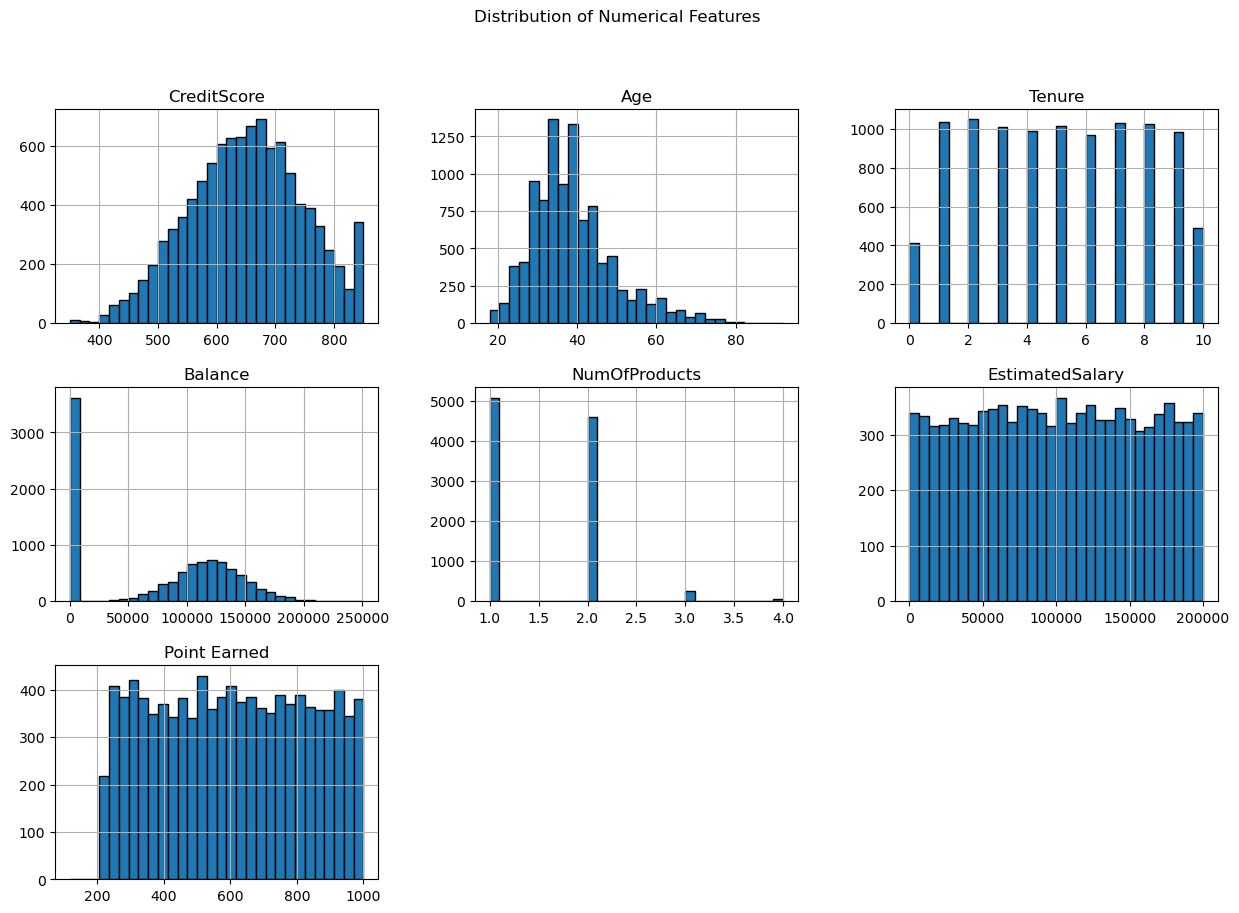

In [13]:
# Plotting histograms for all numerical features
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Point Earned']

df[numerical_features].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.show()

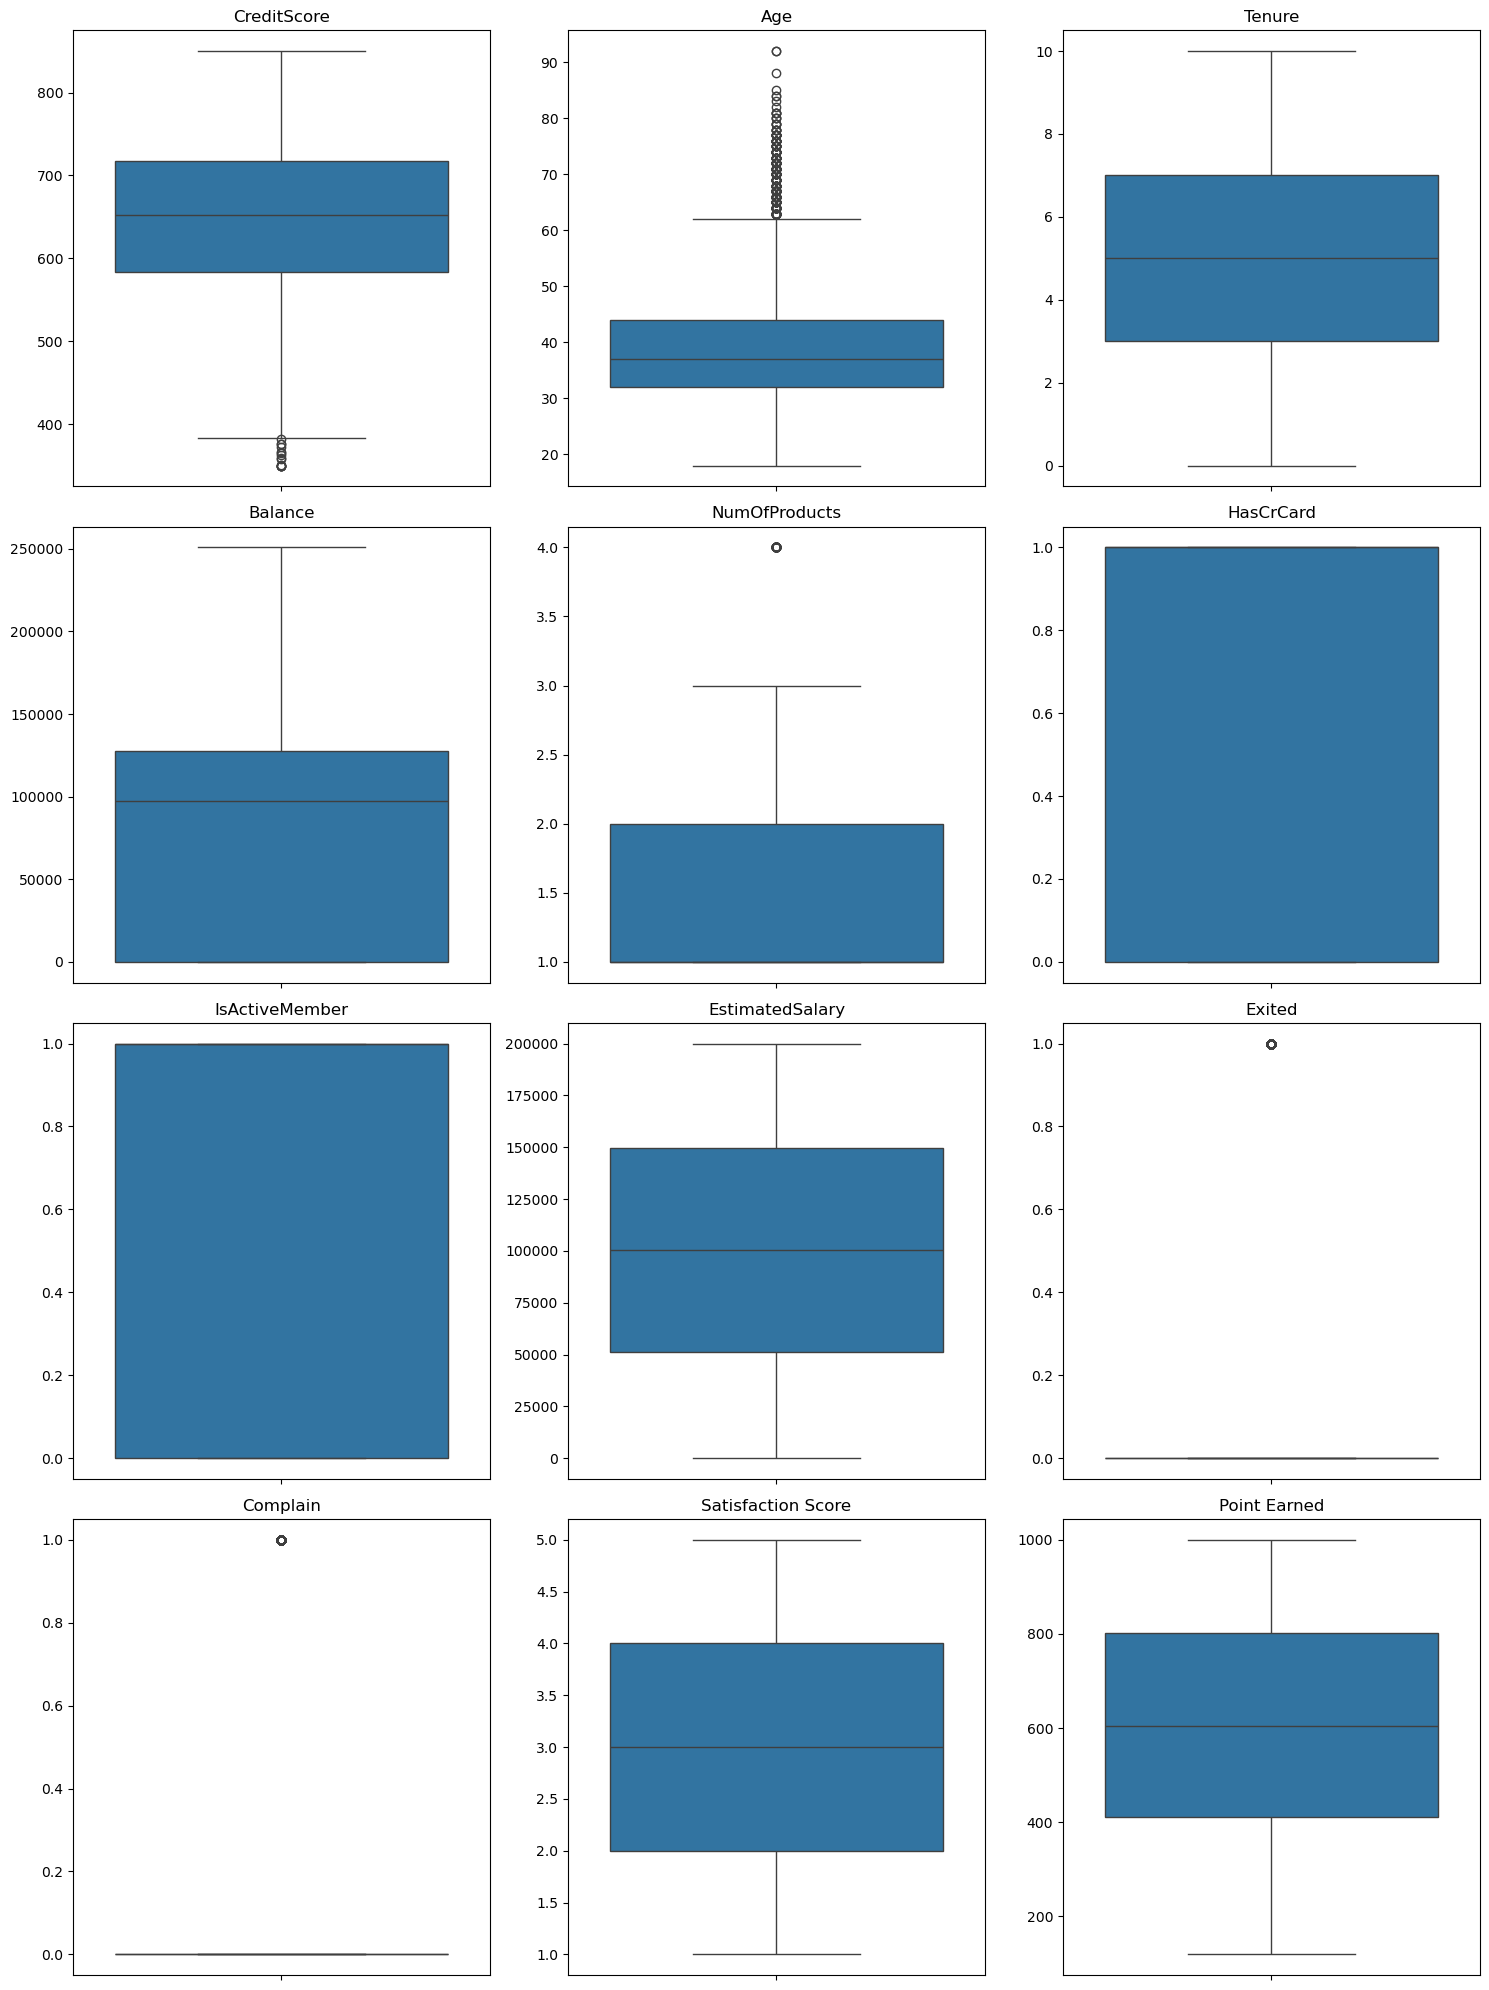

In [14]:
numeric = df.select_dtypes(include=['int64','float64']).columns

# Determine the number of numeric columns to plot
num_cols = len(numeric)

# Define layout: 3 plots per row
cols_per_row = 3
num_rows = int(np.ceil(num_cols / cols_per_row))

# Create subplots grid
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 5))
axes = axes.flatten()

# Generate boxplots for each numeric column
for i, col in enumerate(numeric):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel("")

# Hide any unused subplots if total axes > columns plotted
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Improve spacing between plots
plt.tight_layout()
plt.show()

## Target Variable Distribution

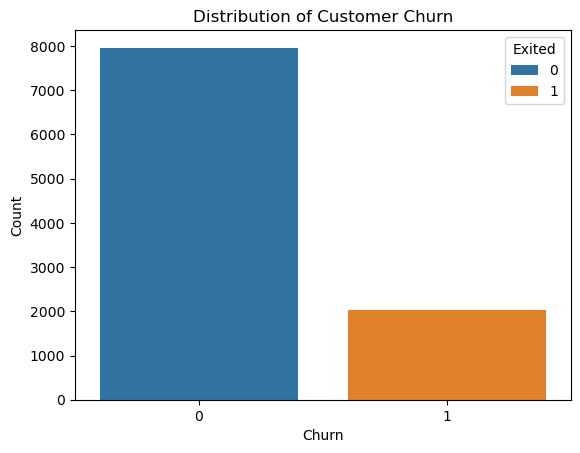

Exited
0    79.62
1    20.38
Name: proportion, dtype: float64


In [16]:
# Checking the distribution of the target variable (Exited)
sns.countplot(data=df, x='Exited', hue='Exited')
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# Printing churn rate in percentages
churn_rate = df['Exited'].value_counts(normalize=True) * 100
print(churn_rate)

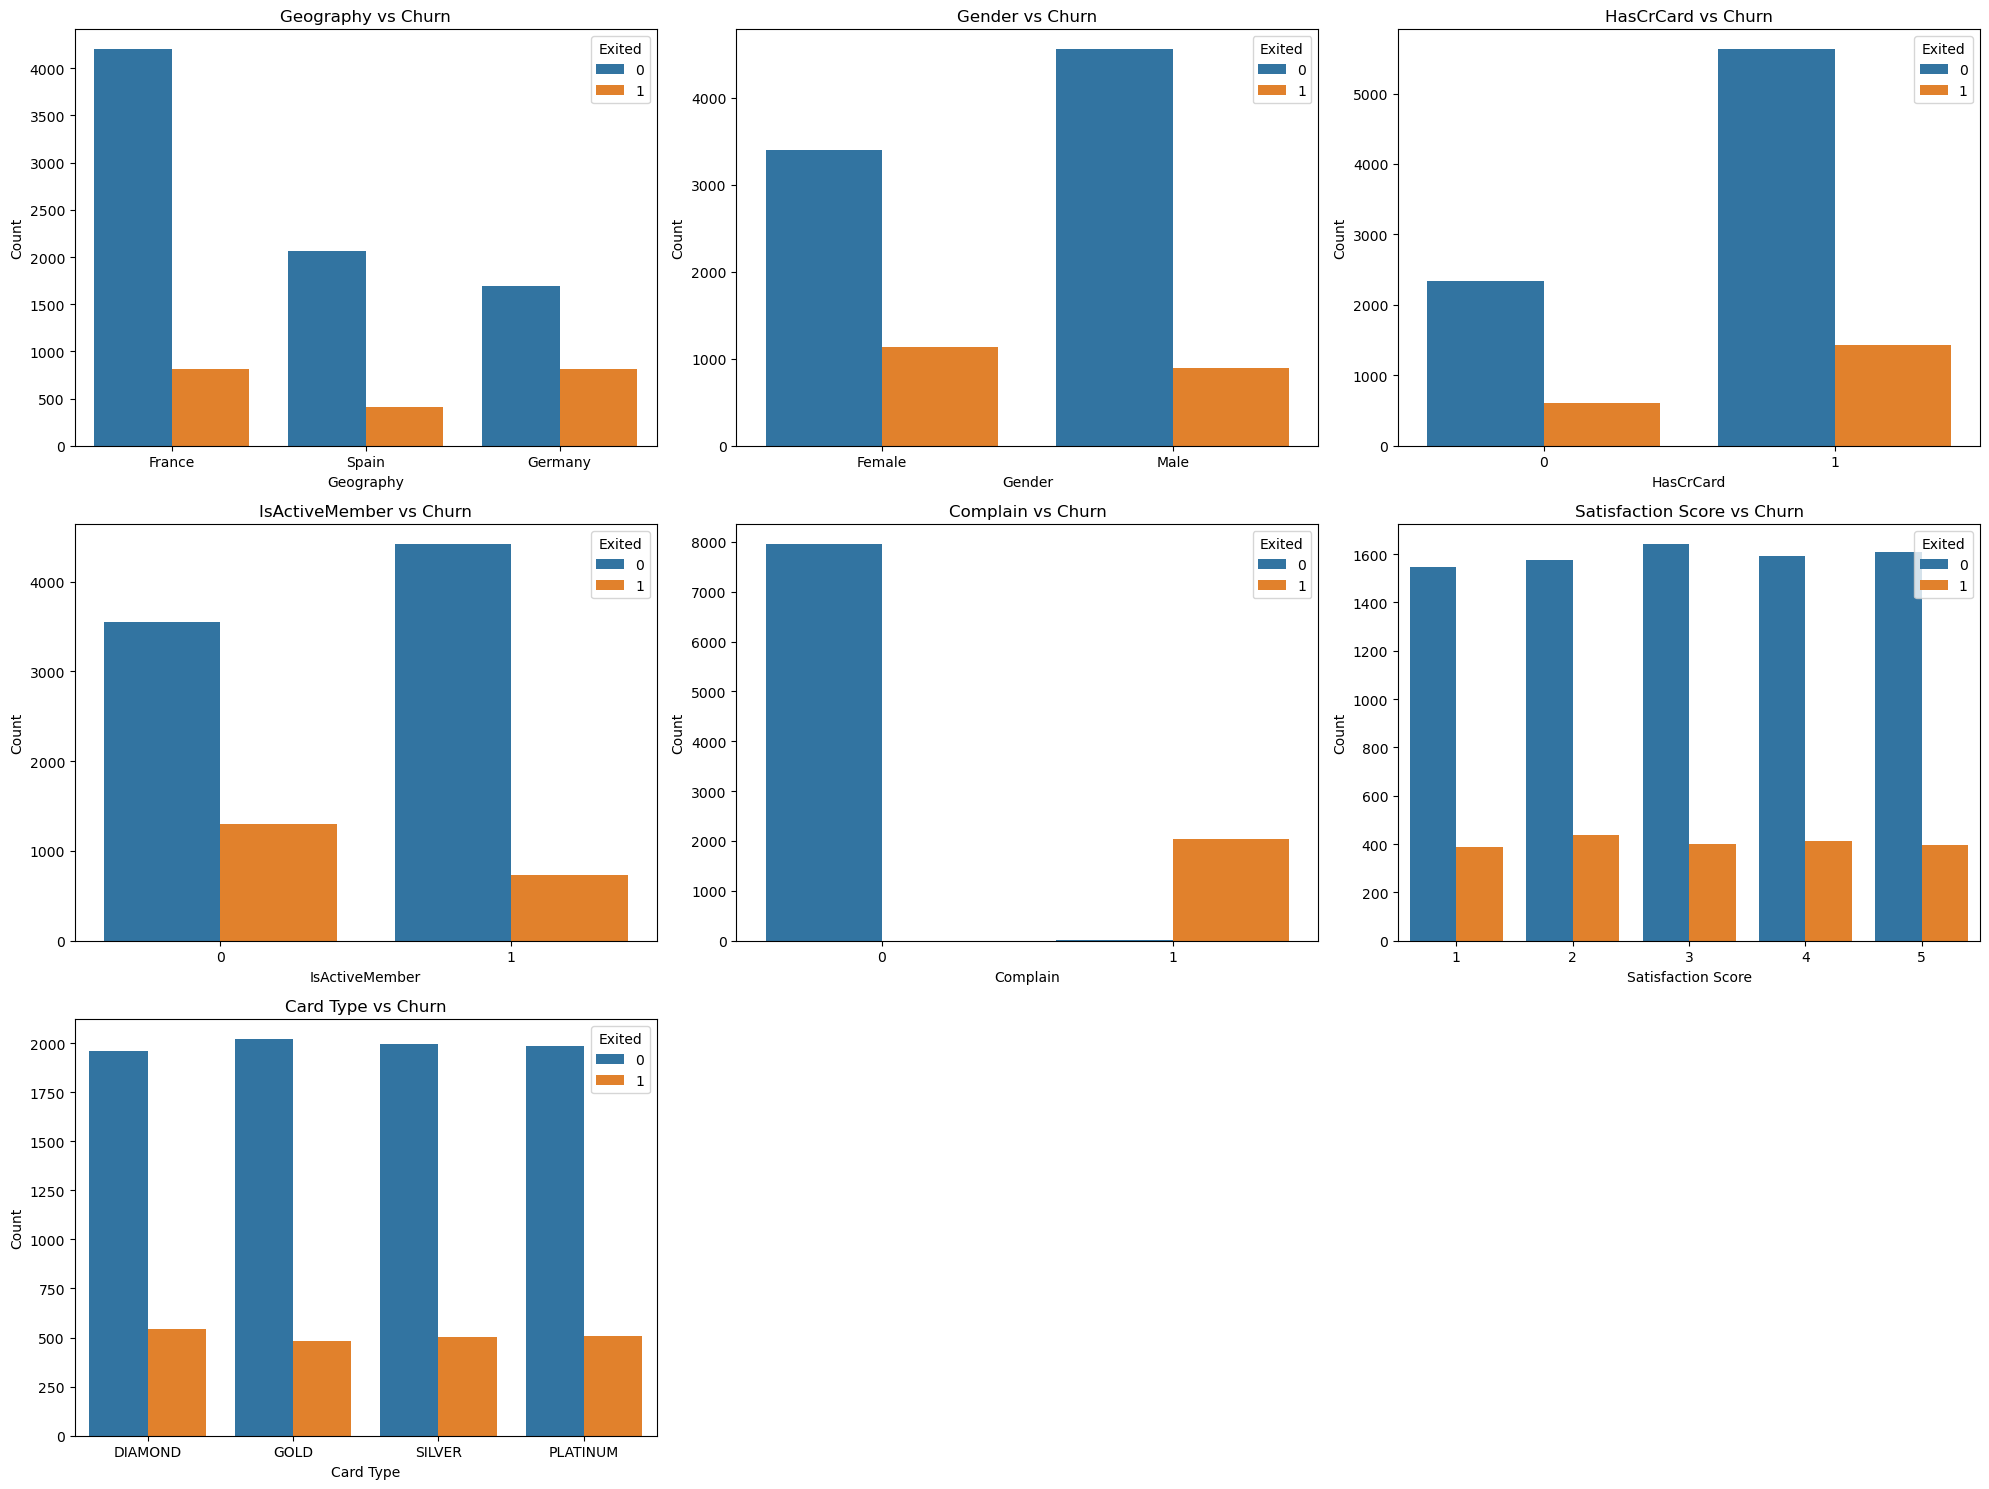

In [17]:
# Plotting categorical features against churn
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Card Type']

plt.figure(figsize=(20, 15))

for idx, feature in enumerate(categorical_features):
    plt.subplot(3, 3, idx+1)
    sns.countplot(data=df, x=feature, hue='Exited')
    plt.title(f'{feature} vs Churn')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


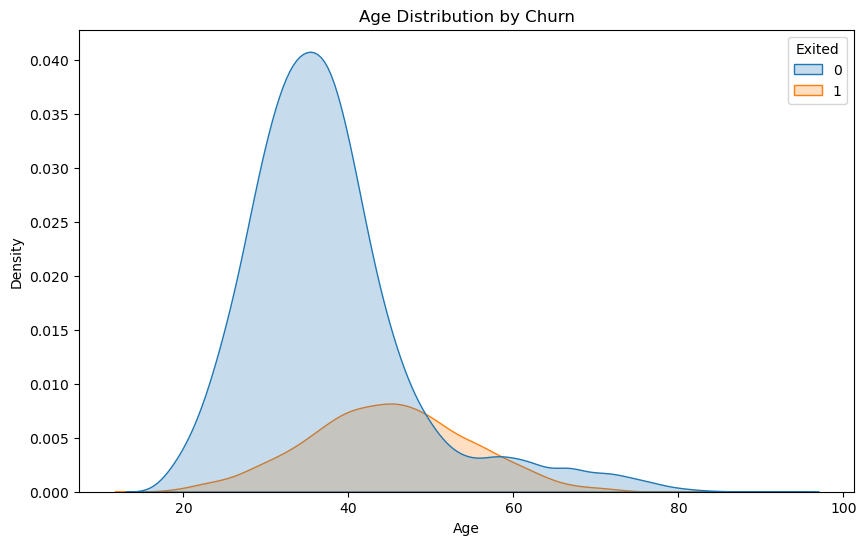

In [18]:
# Plotting age distribution by churn status
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Age', hue='Exited', fill=True)
plt.title('Age Distribution by Churn')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

## Correlation Heatmap

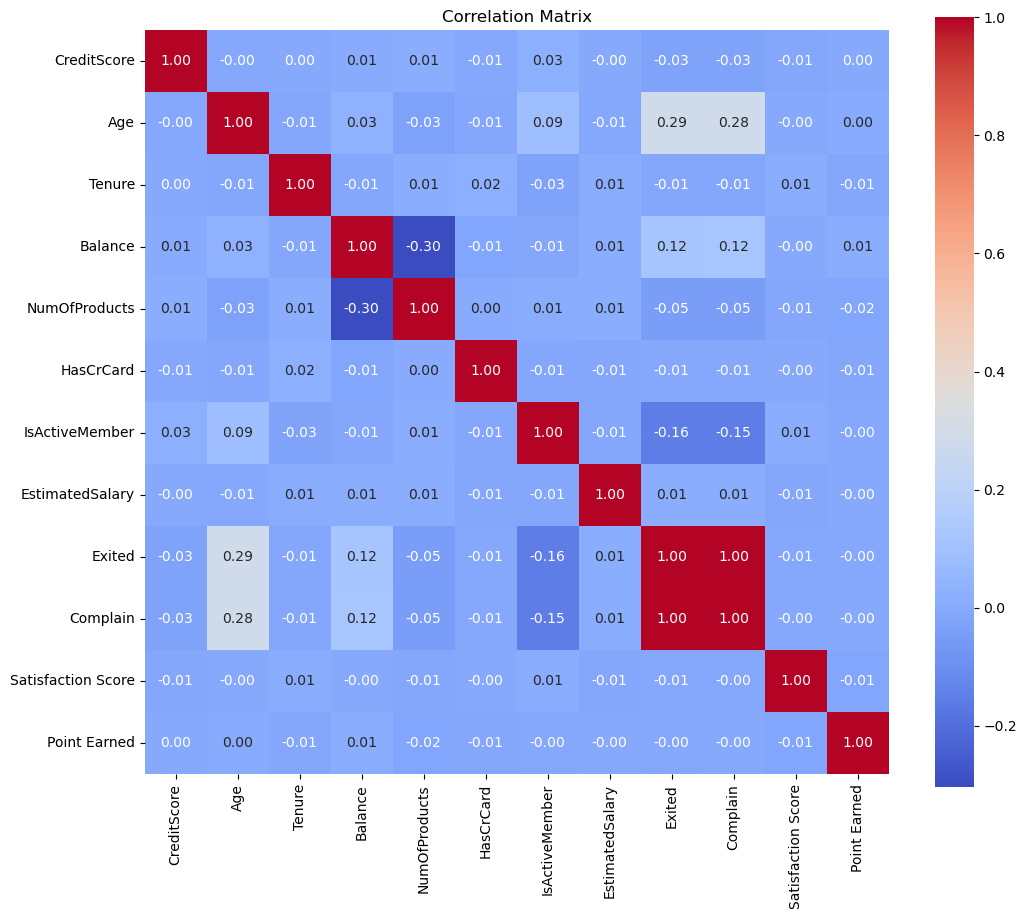

In [20]:
# Correlation matrix for numerical features
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Preprocessing the data

In [22]:
# Dropping the 'Complain' column to avoid information leakage
df.drop('Complain', axis=1, inplace=True)

## Encoding Categorical Variables

In [24]:
# Label Encoding for binary categorical column
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

#Ordinal Encoding in Card Type
card = {'Card_Type': ['DIAMOND', 'GOLD', 'SILVER', 'PLATINUM', 'GOLD', 'DIAMOND']}
card_map = {'DIAMOND': 4, 'GOLD': 2, 'SILVER': 1, 'PLATINUM': 3}
df['Card Type'] = df['Card Type'].map(card_map)
df.head()

# One-Hot Encoding for nominal categorical columns
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# Preparing the Data

In [26]:
# Splitting Data into Features and Target

X = df.drop("Exited", axis=1)
y = df["Exited"]

# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling using StandardScaler

scaler = StandardScaler()

# Fit on training data and transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Applying SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Training Different Models

In [29]:
def evaluate_models(models, X, y, cv_folds=5):
    # Define scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score)
    }

    # Cross-validation strategy
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    results = {}

    for name, model in models.items():
        print(f"Evaluating: {name}")
        cv_results = cross_validate(
            model, X, y,
            cv=cv, scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )
        # Store mean of each score
        results[name] = {
            metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring
        }

    # Convert to DataFrame for easy comparison
    return pd.DataFrame(results).T.sort_values(by='f1', ascending=False)

In [85]:
# Define a dictionary of classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

In [87]:
print("Evaluating models WITHOUT SMOTE...")
results_no_smote = evaluate_models(models, X_train, y_train)

print("\nEvaluating models WITH SMOTE...")
results_smote = evaluate_models(models, X_train_smote, y_train_smote)

Evaluating models WITHOUT SMOTE...
Evaluating: Logistic Regression
Evaluating: Decision Tree
Evaluating: Random Forest
Evaluating: Gradient Boosting
Evaluating: SVM
Evaluating: Naive Bayes
Evaluating: K-Nearest Neighbors
Evaluating: XGBoost
Evaluating: LightGBM

Evaluating models WITH SMOTE...
Evaluating: Logistic Regression
Evaluating: Decision Tree
Evaluating: Random Forest
Evaluating: Gradient Boosting
Evaluating: SVM
Evaluating: Naive Bayes
Evaluating: K-Nearest Neighbors
Evaluating: XGBoost
Evaluating: LightGBM


In [94]:
# Convert to DataFrames for display
df_no_smote = pd.DataFrame(results_no_smote)
df_smote = pd.DataFrame(results_smote)

# Add prefix to distinguish
df_no_smote.columns = [col + ' (no SMOTE)' for col in df_no_smote.columns]
df_smote.columns = [col + ' (SMOTE)' for col in df_smote.columns]

# Combine both
comparison = pd.concat([df_no_smote, df_smote], axis=1)
comparison.sort_values(by='f1 (SMOTE)', ascending=False)

,accuracy (no SMOTE),precision (no SMOTE),recall (no SMOTE),f1 (no SMOTE),roc_auc (no SMOTE),accuracy (SMOTE),precision (SMOTE),recall (SMOTE),f1 (SMOTE),roc_auc (SMOTE)
Random Forest,0.862125,0.792545,0.438037,0.563997,0.704340,0.914914,0.918215,0.910989,0.914577,0.914914
LightGBM,0.857875,0.733496,0.476074,0.577219,0.715823,0.909890,0.935664,0.880377,0.907149,0.909890
XGBoost,0.850250,0.691971,0.480368,0.566649,0.712633,0.906829,0.927732,0.882418,0.904486,0.906829
Gradient Boosting,0.862500,0.770245,0.463190,0.578256,0.713934,0.887598,0.906904,0.863893,0.884868,0.887598
K-Nearest Neighbors,0.763375,0.256619,0.084049,0.126472,0.510627,0.834380,0.771863,0.949451,0.851471,0.834380
Decision Tree,0.784625,0.473795,0.495092,0.483796,0.676902,0.838305,0.832140,0.847567,0.839758,0.838305
SVM,0.796250,0.000000,0.000000,0.000000,0.500000,0.832025,0.822160,0.847410,0.834526,0.832025
Naive Bayes,0.784875,0.358830,0.069325,0.116014,0.518650,0.719466,0.731150,0.694349,0.712143,0.719466
Logistic Regression,0.788625,0.388923,0.058896,0.102063,0.517124,0.710047,0.712619,0.704082,0.708267,0.710047


## Comparing Models With and Without SMOTE

In [34]:
def train_and_compare_model(model, model_name, X_train, y_train, X_train_smote, y_train_smote, X_test, y_test):
    """
    Trains a model with and without SMOTE, evaluates it, and plots side-by-side confusion matrices and classification reports.
    """
    print(f"\nEvaluating {model_name}...\n")

    # Train without SMOTE
    model_no_smote = model
    model_no_smote.fit(X_train, y_train)
    y_pred_no_smote = model_no_smote.predict(X_test)

    # Train with SMOTE
    model_with_smote = model.__class__(**model.get_params())
    model_with_smote.fit(X_train_smote, y_train_smote)
    y_pred_with_smote = model_with_smote.predict(X_test)

    # Setup figure for side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Confusion Matrix - No SMOTE
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_no_smote, ax=axes[0], cmap="Blues")
    axes[0].set_title(f"{model_name} - Without SMOTE")

    # Confusion Matrix - With SMOTE
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_with_smote, ax=axes[1], cmap="Greens")
    axes[1].set_title(f"{model_name} - With SMOTE")

    plt.tight_layout()
    plt.show()

    # Classification Reports
    print("Classification Report - Without SMOTE:")
    print(classification_report(y_test, y_pred_no_smote, digits=4))

    print("\nClassification Report - With SMOTE:")
    print(classification_report(y_test, y_pred_with_smote, digits=4))



Evaluating Logistic Regression...



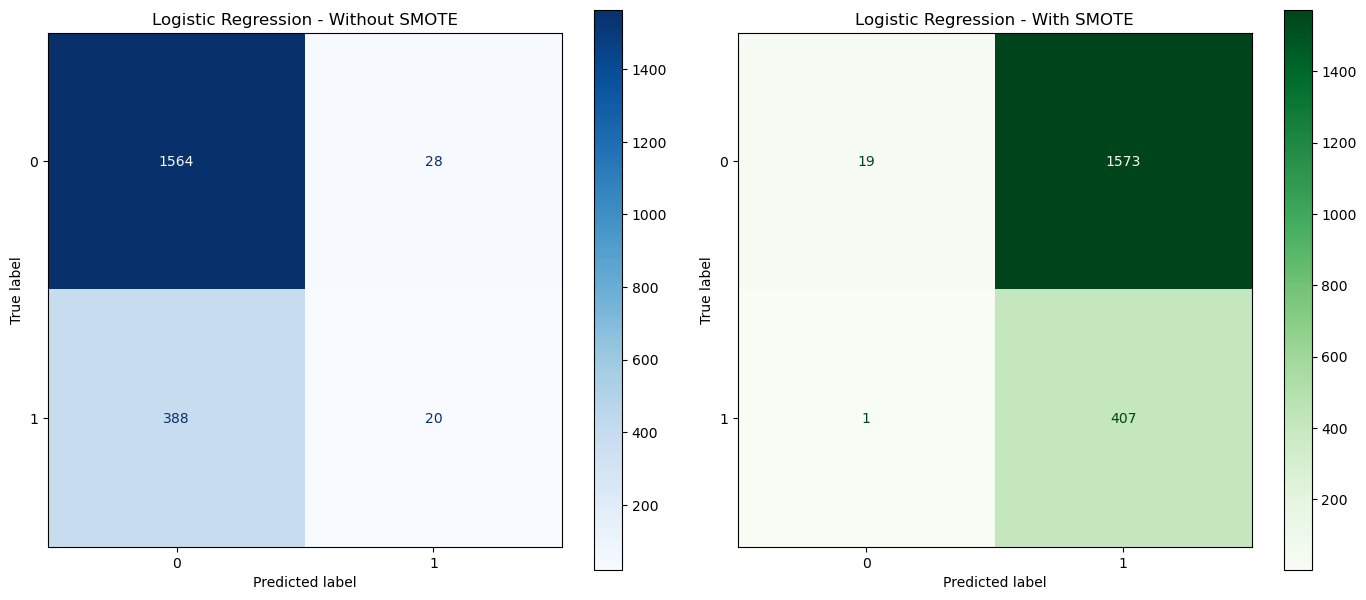

Classification Report - Without SMOTE:
              precision    recall  f1-score   support

           0     0.8012    0.9824    0.8826      1592
           1     0.4167    0.0490    0.0877       408

    accuracy                         0.7920      2000
   macro avg     0.6089    0.5157    0.4852      2000
weighted avg     0.7228    0.7920    0.7205      2000


Classification Report - With SMOTE:
              precision    recall  f1-score   support

           0     0.9500    0.0119    0.0236      1592
           1     0.2056    0.9975    0.3409       408

    accuracy                         0.2130      2000
   macro avg     0.5778    0.5047    0.1822      2000
weighted avg     0.7981    0.2130    0.0883      2000


Evaluating Decision Tree...



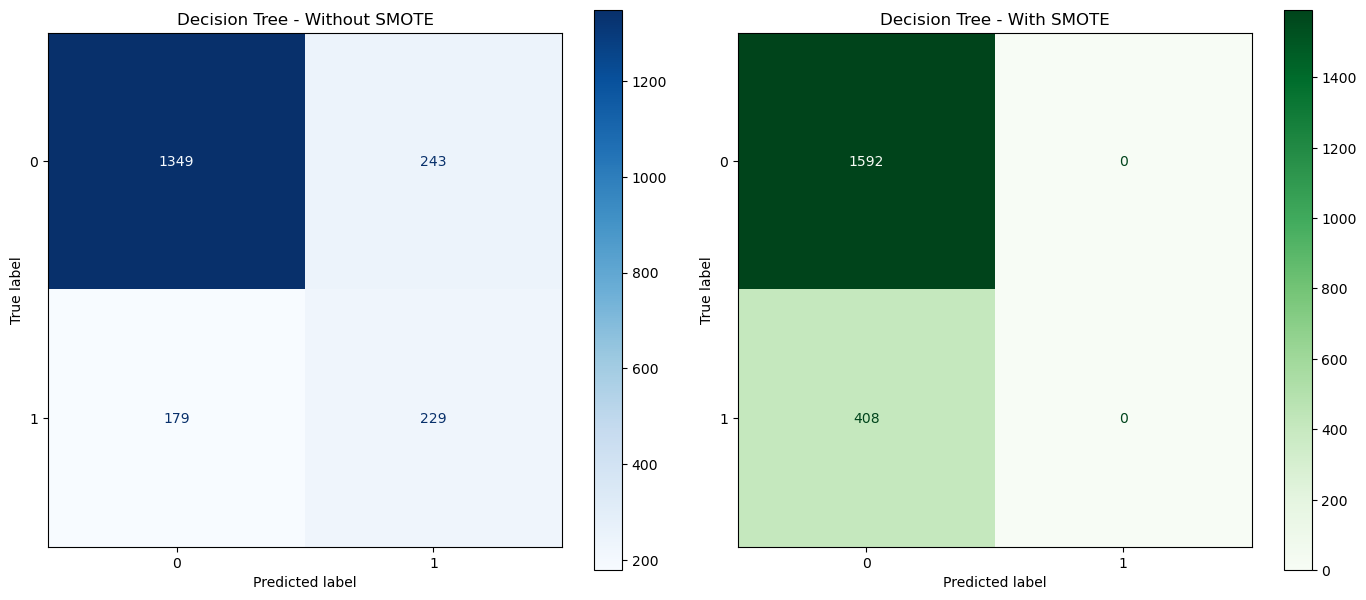

Classification Report - Without SMOTE:
              precision    recall  f1-score   support

           0     0.8829    0.8474    0.8647      1592
           1     0.4852    0.5613    0.5205       408

    accuracy                         0.7890      2000
   macro avg     0.6840    0.7043    0.6926      2000
weighted avg     0.8017    0.7890    0.7945      2000


Classification Report - With SMOTE:
              precision    recall  f1-score   support

           0     0.7960    1.0000    0.8864      1592
           1     0.0000    0.0000    0.0000       408

    accuracy                         0.7960      2000
   macro avg     0.3980    0.5000    0.4432      2000
weighted avg     0.6336    0.7960    0.7056      2000


Evaluating Random Forest...



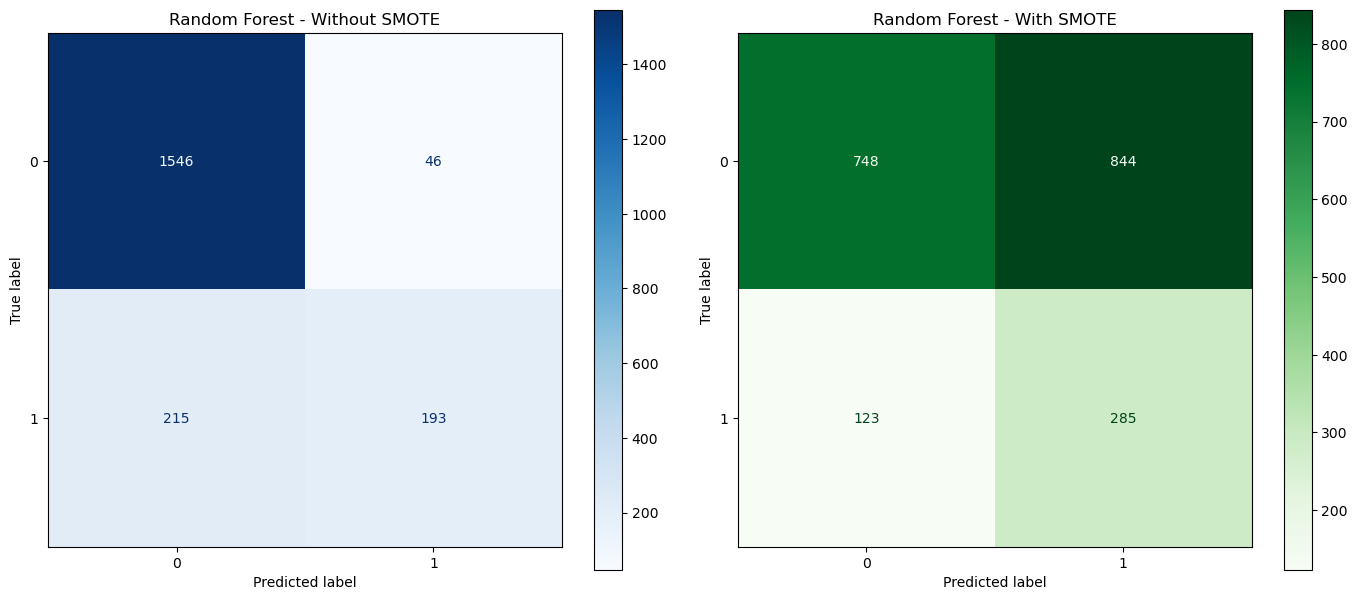

Classification Report - Without SMOTE:
              precision    recall  f1-score   support

           0     0.8779    0.9711    0.9222      1592
           1     0.8075    0.4730    0.5966       408

    accuracy                         0.8695      2000
   macro avg     0.8427    0.7221    0.7594      2000
weighted avg     0.8636    0.8695    0.8557      2000


Classification Report - With SMOTE:
              precision    recall  f1-score   support

           0     0.8588    0.4698    0.6074      1592
           1     0.2524    0.6985    0.3709       408

    accuracy                         0.5165      2000
   macro avg     0.5556    0.5842    0.4891      2000
weighted avg     0.7351    0.5165    0.5591      2000


Evaluating Gradient Boosting...



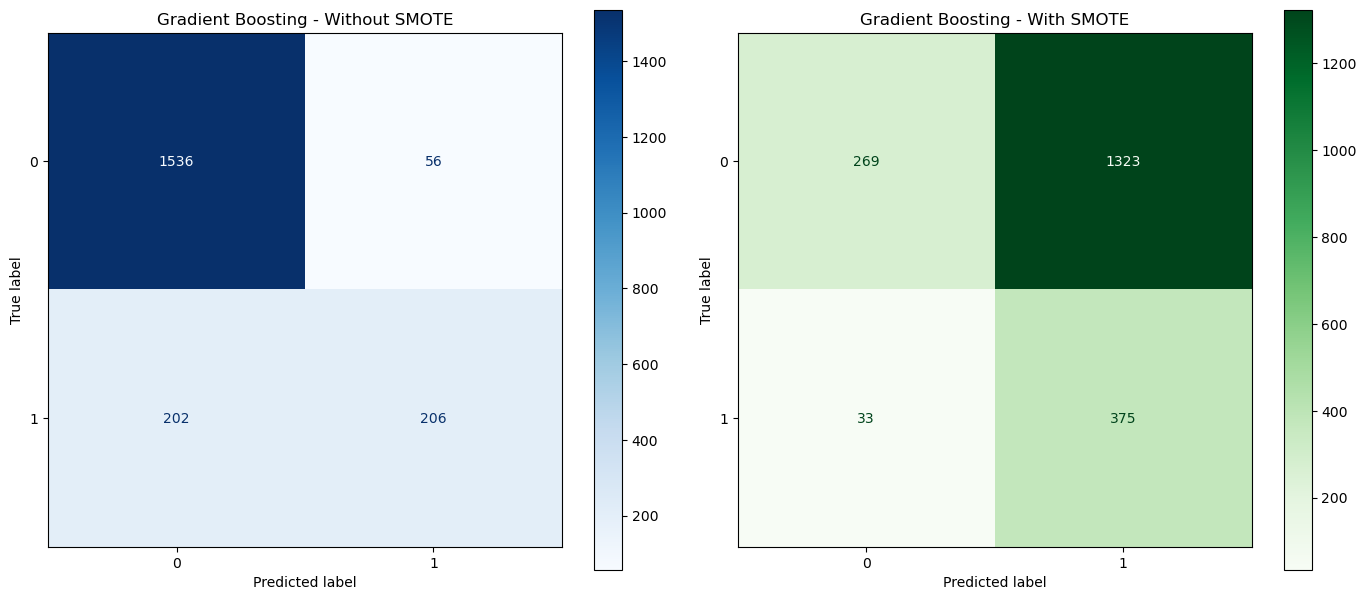

Classification Report - Without SMOTE:
              precision    recall  f1-score   support

           0     0.8838    0.9648    0.9225      1592
           1     0.7863    0.5049    0.6149       408

    accuracy                         0.8710      2000
   macro avg     0.8350    0.7349    0.7687      2000
weighted avg     0.8639    0.8710    0.8598      2000


Classification Report - With SMOTE:
              precision    recall  f1-score   support

           0     0.8907    0.1690    0.2841      1592
           1     0.2208    0.9191    0.3561       408

    accuracy                         0.3220      2000
   macro avg     0.5558    0.5440    0.3201      2000
weighted avg     0.7541    0.3220    0.2988      2000


Evaluating Support Vector Machine...



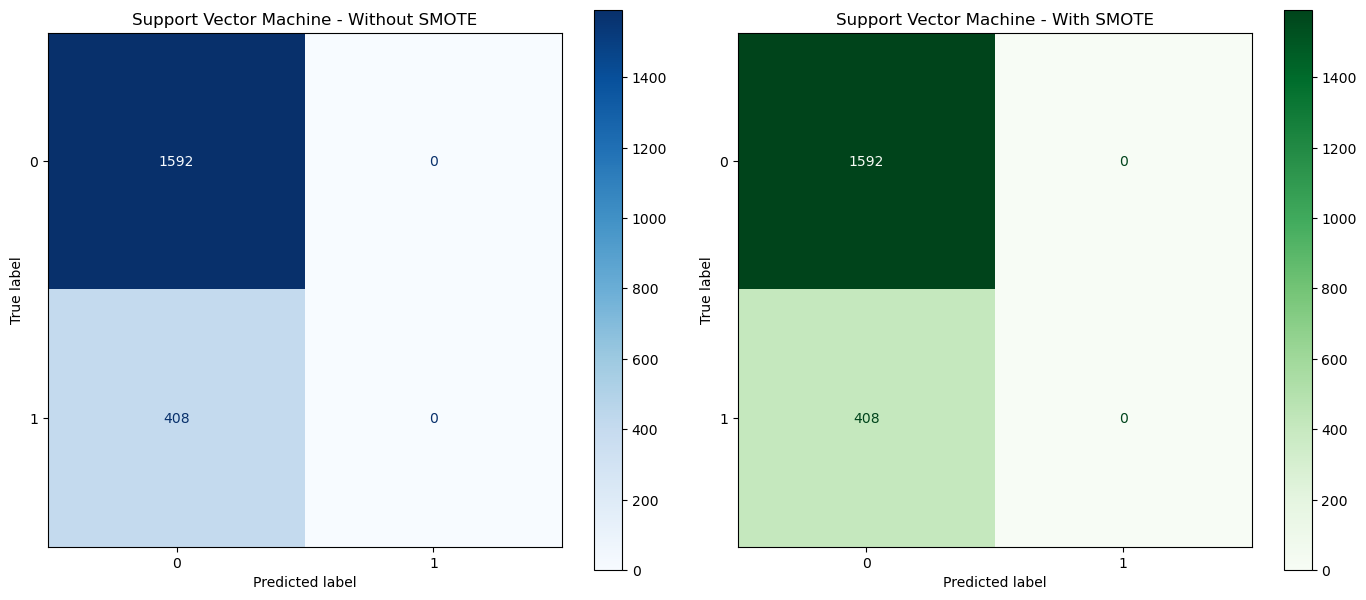

Classification Report - Without SMOTE:
              precision    recall  f1-score   support

           0     0.7960    1.0000    0.8864      1592
           1     0.0000    0.0000    0.0000       408

    accuracy                         0.7960      2000
   macro avg     0.3980    0.5000    0.4432      2000
weighted avg     0.6336    0.7960    0.7056      2000


Classification Report - With SMOTE:
              precision    recall  f1-score   support

           0     0.7960    1.0000    0.8864      1592
           1     0.0000    0.0000    0.0000       408

    accuracy                         0.7960      2000
   macro avg     0.3980    0.5000    0.4432      2000
weighted avg     0.6336    0.7960    0.7056      2000


Evaluating Naive Bayes...



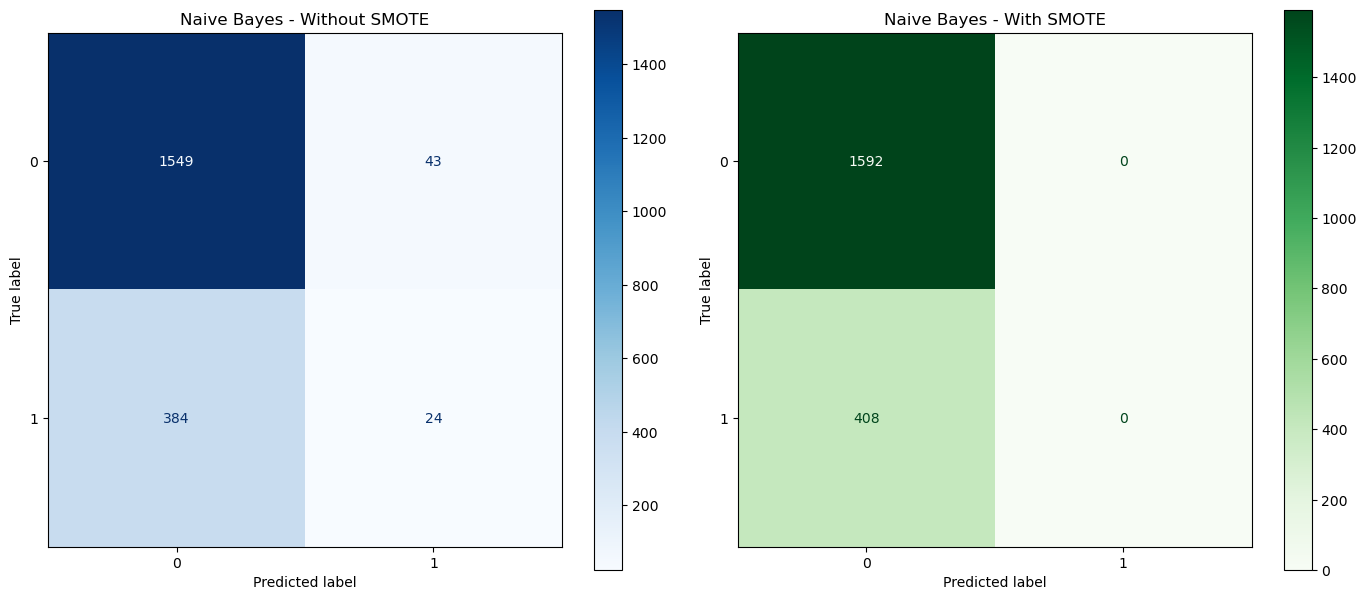

Classification Report - Without SMOTE:
              precision    recall  f1-score   support

           0     0.8013    0.9730    0.8789      1592
           1     0.3582    0.0588    0.1011       408

    accuracy                         0.7865      2000
   macro avg     0.5798    0.5159    0.4900      2000
weighted avg     0.7109    0.7865    0.7202      2000


Classification Report - With SMOTE:
              precision    recall  f1-score   support

           0     0.7960    1.0000    0.8864      1592
           1     0.0000    0.0000    0.0000       408

    accuracy                         0.7960      2000
   macro avg     0.3980    0.5000    0.4432      2000
weighted avg     0.6336    0.7960    0.7056      2000


Evaluating K-Nearest Neighbors...



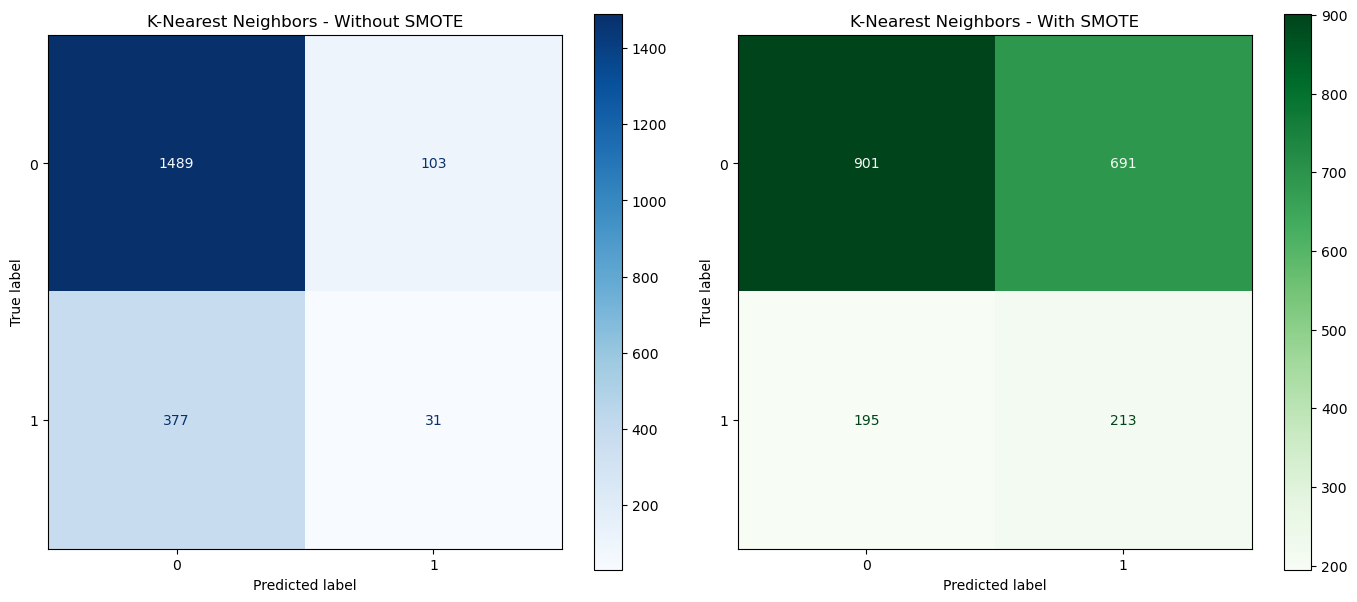

Classification Report - Without SMOTE:
              precision    recall  f1-score   support

           0     0.7980    0.9353    0.8612      1592
           1     0.2313    0.0760    0.1144       408

    accuracy                         0.7600      2000
   macro avg     0.5147    0.5056    0.4878      2000
weighted avg     0.6824    0.7600    0.7088      2000


Classification Report - With SMOTE:
              precision    recall  f1-score   support

           0     0.8221    0.5660    0.6704      1592
           1     0.2356    0.5221    0.3247       408

    accuracy                         0.5570      2000
   macro avg     0.5288    0.5440    0.4975      2000
weighted avg     0.7024    0.5570    0.5999      2000


Evaluating XGBoost...



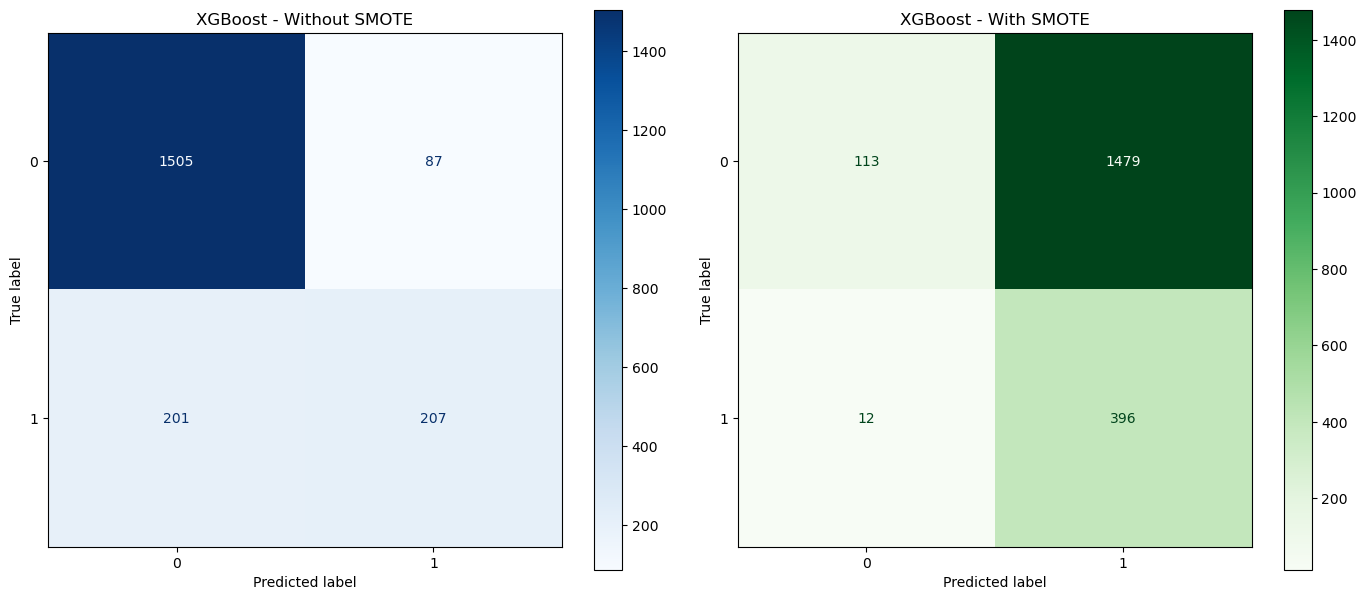

Classification Report - Without SMOTE:
              precision    recall  f1-score   support

           0     0.8822    0.9454    0.9127      1592
           1     0.7041    0.5074    0.5897       408

    accuracy                         0.8560      2000
   macro avg     0.7931    0.7264    0.7512      2000
weighted avg     0.8458    0.8560    0.8468      2000


Classification Report - With SMOTE:
              precision    recall  f1-score   support

           0     0.9040    0.0710    0.1316      1592
           1     0.2112    0.9706    0.3469       408

    accuracy                         0.2545      2000
   macro avg     0.5576    0.5208    0.2393      2000
weighted avg     0.7627    0.2545    0.1755      2000


Evaluating LightGBM...

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 s

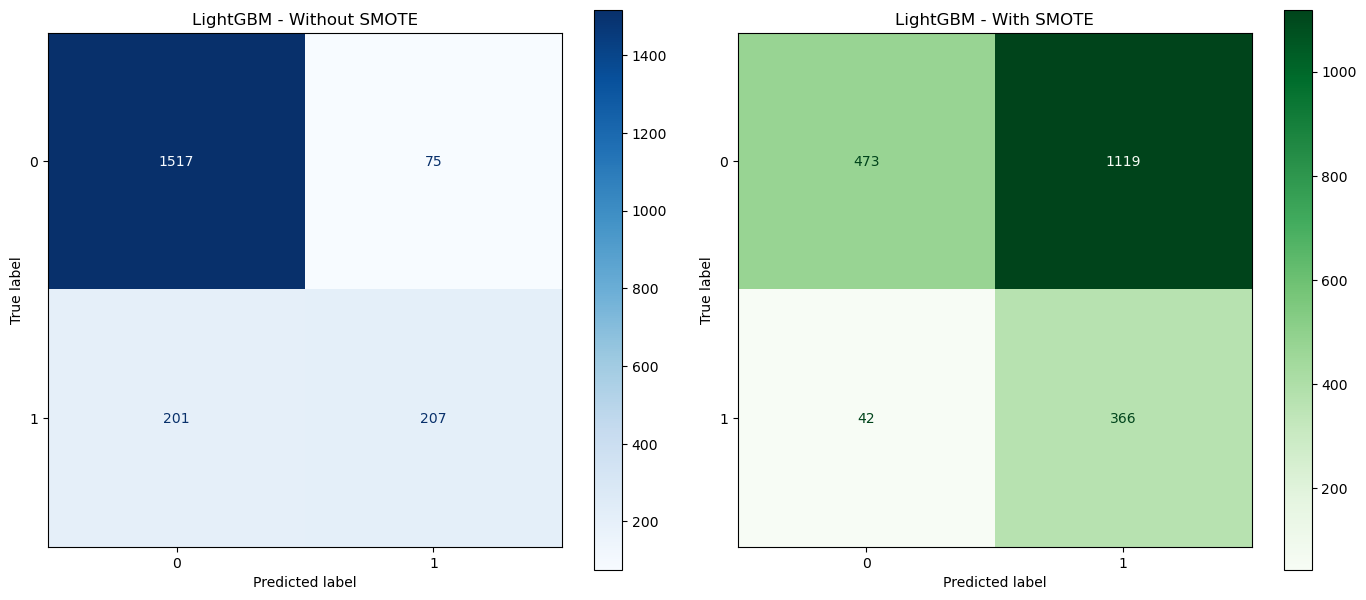

Classification Report - Without SMOTE:
              precision    recall  f1-score   support

           0     0.8830    0.9529    0.9166      1592
           1     0.7340    0.5074    0.6000       408

    accuracy                         0.8620      2000
   macro avg     0.8085    0.7301    0.7583      2000
weighted avg     0.8526    0.8620    0.8520      2000


Classification Report - With SMOTE:
              precision    recall  f1-score   support

           0     0.9184    0.2971    0.4490      1592
           1     0.2465    0.8971    0.3867       408

    accuracy                         0.4195      2000
   macro avg     0.5825    0.5971    0.4178      2000
weighted avg     0.7814    0.4195    0.4363      2000



In [92]:
# Run for each model
train_and_compare_model(LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression", 
                        X_train, y_train, X_train_smote, y_train_smote, X_test, y_test)

train_and_compare_model(DecisionTreeClassifier(random_state=42), "Decision Tree", 
                        X_train, y_train, X_train_smote, y_train_smote, X_test, y_test)

train_and_compare_model(RandomForestClassifier(random_state=42), "Random Forest", 
                        X_train, y_train, X_train_smote, y_train_smote, X_test, y_test)

train_and_compare_model(GradientBoostingClassifier(random_state=42), "Gradient Boosting", 
                        X_train, y_train, X_train_smote, y_train_smote, X_test, y_test)

train_and_compare_model(SVC(probability=True, random_state=42), "Support Vector Machine", 
                        X_train, y_train, X_train_smote, y_train_smote, X_test, y_test)

train_and_compare_model(GaussianNB(), "Naive Bayes", 
                        X_train, y_train, X_train_smote, y_train_smote, X_test, y_test)

train_and_compare_model(KNeighborsClassifier(), "K-Nearest Neighbors", 
                        X_train, y_train, X_train_smote, y_train_smote, X_test, y_test)

train_and_compare_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), "XGBoost", 
                        X_train, y_train, X_train_smote, y_train_smote, X_test, y_test)

train_and_compare_model(LGBMClassifier(random_state=42), "LightGBM", 
                        X_train, y_train, X_train_smote, y_train_smote, X_test, y_test)


In [96]:
def plot_roc_pr_curves(models, X_test, y_test, title_prefix="Without SMOTE"):
    plt.figure(figsize=(14, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve - {title_prefix}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
        plt.plot(recall, precision, label=f"{name} (AP = {pr_auc:.2f})")
    plt.title(f"Precision-Recall Curve - {title_prefix}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [98]:
def train_models_with_and_without_smote(X_train, y_train, X_test, y_test):
    base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
    }

    models_no_smote = {}
    models_smote = {}

    print("Training models WITHOUT SMOTE...")
    for name, model in base_models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        models_no_smote[name] = model

    print("\nTraining models WITH SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    for name, model in base_models.items():
        print(f"Training {name} with SMOTE...")
        model_clone = clone(model)
        model_clone.fit(X_train_smote, y_train_smote)
        models_smote[name] = model_clone

    return models_no_smote, models_smote

In [100]:
models_no_smote, models_smote = train_models_with_and_without_smote(X_train, y_train, X_test, y_test)

Training models WITHOUT SMOTE...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training SVM...
Training Naive Bayes...
Training K-Nearest Neighbors...
Training XGBoost...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1122
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019

Training models WITH SMOTE...
Training Logistic Regression with SMOTE...
Training Decision Tree with SMOTE...
Training Random Forest with SMOTE...
Training Gradient Boo

Plotting curves for models WITHOUT SMOTE...


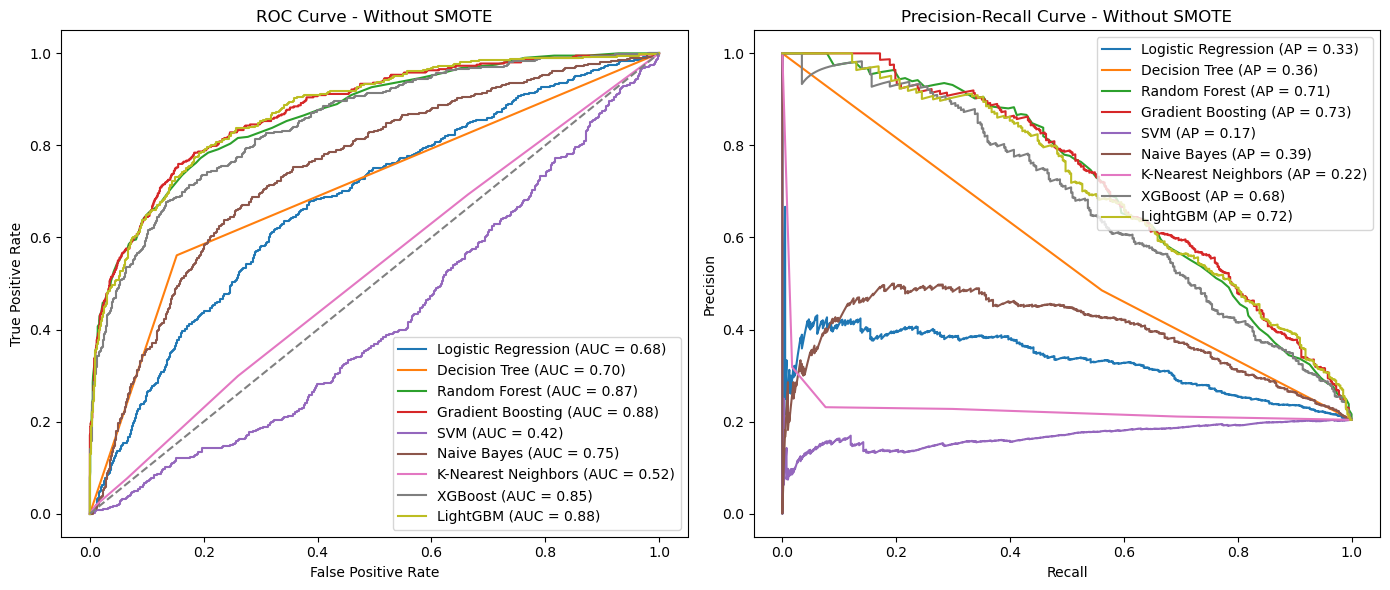

Plotting curves for models WITH SMOTE...


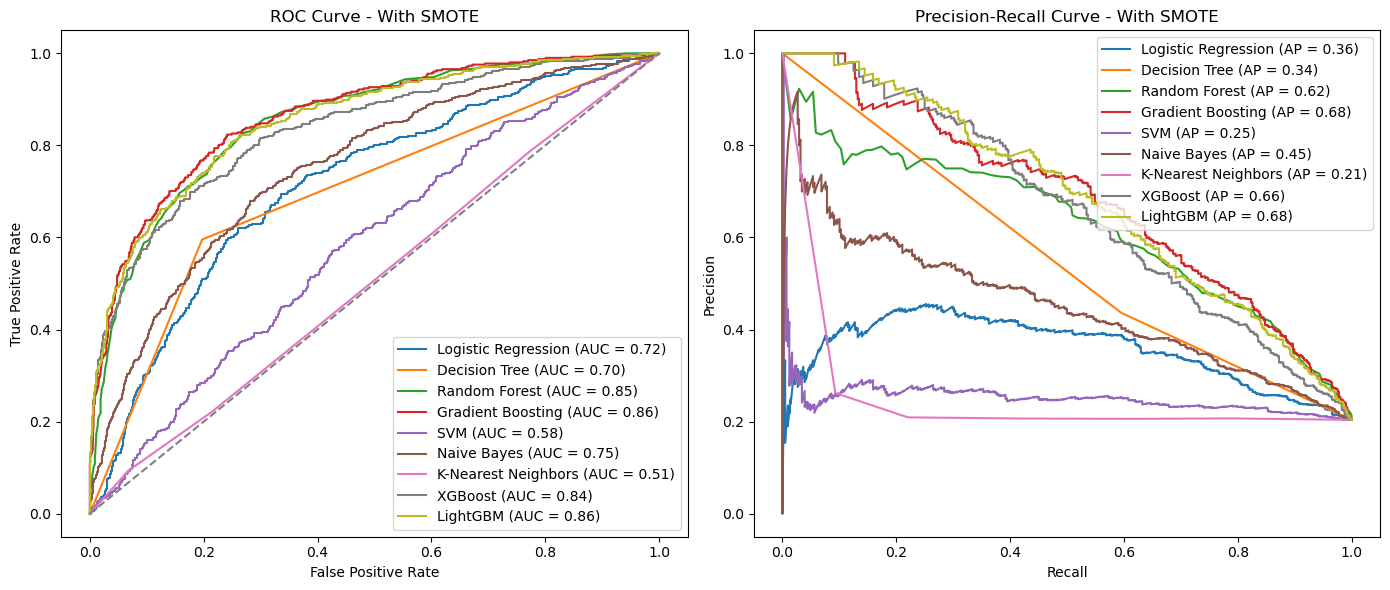

In [106]:
print("Plotting curves for models WITHOUT SMOTE...")
plot_roc_pr_curves(models_no_smote, X_test, y_test, title_prefix="Without SMOTE")

print("Plotting curves for models WITH SMOTE...")
plot_roc_pr_curves(models_smote, X_test, y_test, title_prefix="With SMOTE")

In [40]:
'''After evaluating the models with and without SMOTE using ROC and Precision-Recall curves, 
it became clear that Random Forest and Gradient Boosting classifiers performed the best overall. 
Without SMOTE, their ROC and PR curves were curved,indicating a good trade-off between true positive and false positive rates. 
However, when trained with SMOTE, the curves became more linear, suggesting poor generalization and an imbalanced trade-off. 
This behavior indicates that SMOTE may be introducing too many synthetic patterns,
causing the model to overfit the minority class while sacrificing performance on the majority class.'''

'After evaluating the models with and without SMOTE using ROC and Precision-Recall curves, \nit became clear that Random Forest and Gradient Boosting classifiers performed the best overall. \nWithout SMOTE, their ROC and PR curves were curved,indicating a good trade-off between true positive and false positive rates. \nHowever, when trained with SMOTE, the curves became more linear, suggesting poor generalization and an imbalanced trade-off. \nThis behavior indicates that SMOTE may be introducing too many synthetic patterns,\ncausing the model to overfit the minority class while sacrificing performance on the majority class.'

## Training With GridBoostCV

In [118]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Result dictionary
results = {}

# Gradient Boosting
print("\nGridSearch - Gradient Boosting")
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__subsample': [0.8, 1.0]
}

start = time.time()
gb_grid = GridSearchCV(gb_pipeline, gb_param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
gb_grid.fit(X_train, y_train)
end = time.time()

results['GradientBoosting'] = {
    'best_model': gb_grid.best_estimator_,
    'best_params': gb_grid.best_params_,
    'best_score': gb_grid.best_score_,
    'fit_time': end - start
}


# XGBoost
print("\nGridSearch - XGBoost")
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

start = time.time()
xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
xgb_grid.fit(X_train, y_train)
end = time.time()

results['XGBoost'] = {
    'best_model': xgb_grid.best_estimator_,
    'best_params': xgb_grid.best_params_,
    'best_score': xgb_grid.best_score_,
    'fit_time': end - start
}


# Random Forest
print("\nGridSearch - Random Forest")
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__max_features': ['sqrt', 'log2']
}

start = time.time()
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
rf_grid.fit(X_train, y_train)
end = time.time()

results['RandomForest'] = {
    'best_model': rf_grid.best_estimator_,
    'best_params': rf_grid.best_params_,
    'best_score': rf_grid.best_score_,
    'fit_time': end - start
}


GridSearch - Gradient Boosting
Fitting 5 folds for each of 16 candidates, totalling 80 fits

GridSearch - XGBoost
Fitting 5 folds for each of 32 candidates, totalling 160 fits

GridSearch - Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [119]:
print("\nGridSearchCV Results Summary:")
for model_name, data in results.items():
    print(f"\nModel: {model_name}")
    print(f"Best F1 Score (CV): {data['best_score']:.4f}")
    print(f"Best Params: {data['best_params']}")
    print(f"Training Time: {data['fit_time']:.2f} seconds")


GridSearchCV Results Summary:

Model: GradientBoosting
Best F1 Score (CV): 0.5822
Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Training Time: 10.49 seconds

Model: XGBoost
Best F1 Score (CV): 0.5898
Best Params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Training Time: 1.70 seconds

Model: RandomForest
Best F1 Score (CV): 0.5673
Best Params: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Training Time: 7.46 seconds


## Choosing the Best Model

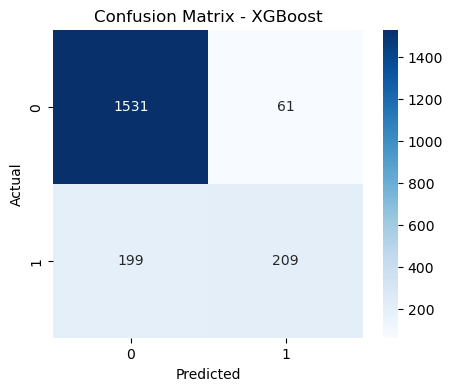

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1592
           1       0.77      0.51      0.62       408

    accuracy                           0.87      2000
   macro avg       0.83      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



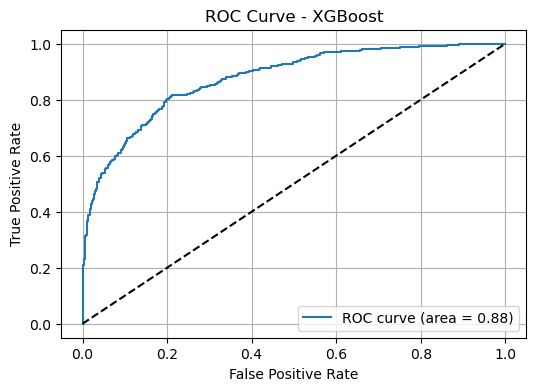

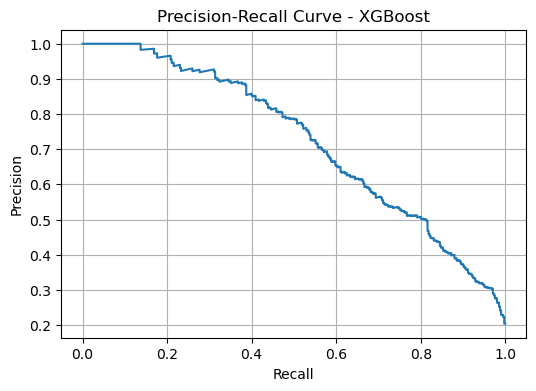

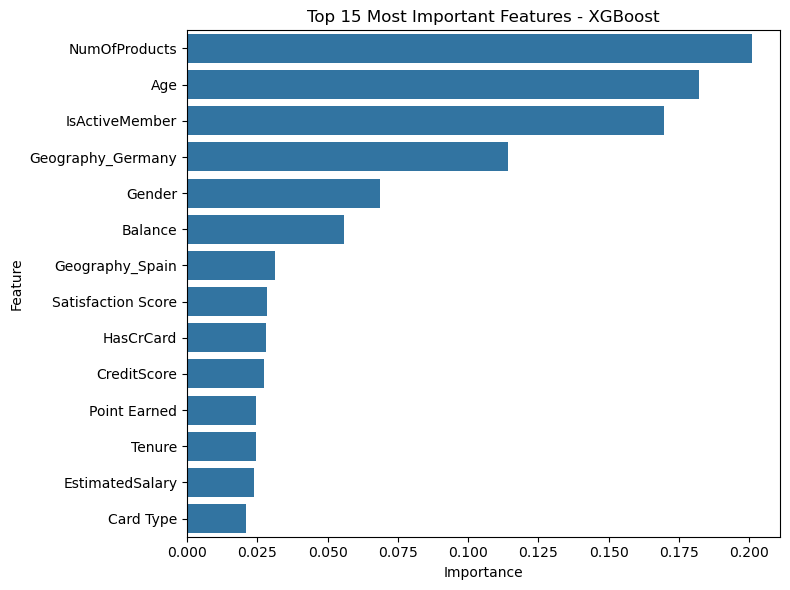

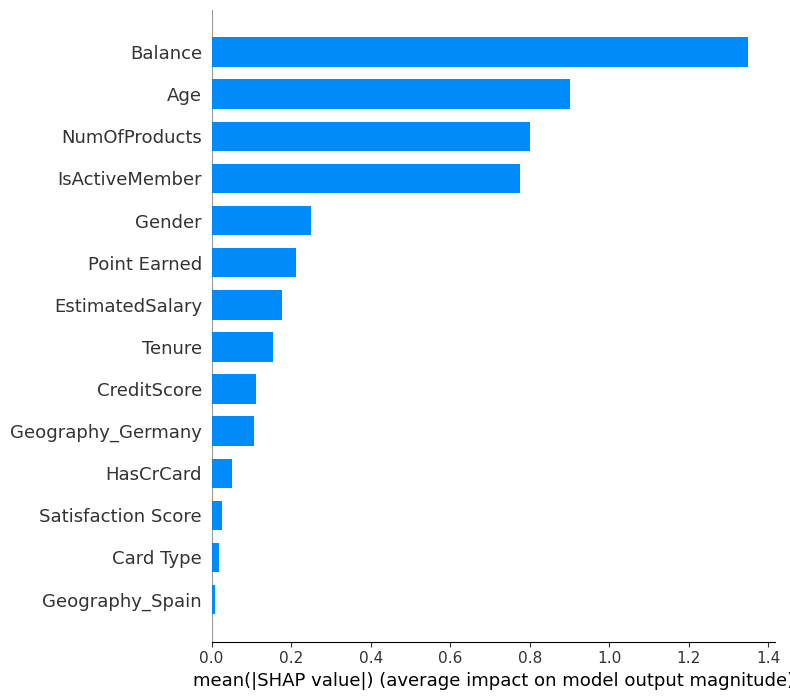

In [130]:
# Refit the best model on the entire training set
final_model = results['XGBoost']['best_model']
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]  # Probabilidades da classe 1

# 1. Confusion Matrix
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2. Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label="Precision-Recall curve")
plt.title("Precision-Recall Curve - XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# 5. Feature Importance (Bar Plot)
importances = final_model.named_steps['classifier'].feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Most Important Features - XGBoost')
plt.tight_layout()
plt.show()

# 6. SHAP values (optional, mais visual e explicativo)
explainer = shap.Explainer(final_model.named_steps['classifier'])
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")